In [38]:
## Link to repository - https://github.com/biony1209/DSCI-510-Final-Project

# Data Collection and Preparation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
covid = pd.read_csv(r'C:\Users\jaimv\Downloads\covid.csv')
noncovid = pd.read_csv(r'C:\Users\jaimv\Downloads\noncovid.csv')

In [42]:
#df = pd.read_csv('../data/covidsample.csv')

In [43]:
covid.rename({'date_died': 'outcome'}, axis=1, inplace=True)

In [44]:
noncovid = noncovid[["ID", "outcome", "age", "gendera", "hypertensive", "diabetes"]]

In [45]:
noncovid.rename({'ID': 'id', 'gendera': 'sex', 'hypertensive': 'hypertension'}, axis=1, inplace=True)

In [46]:
transform={2:1,1:0}
covid = covid.replace({'sex':transform,'hypertension':transform, 'diabetes':transform})

In [47]:
noncovid = noncovid.replace({'sex':transform})

In [48]:
covid['outcome'][covid['outcome']!='9999-99-99']=1.0

C:\Users\jaimv\AppData\Local\Temp/ipykernel_8392/4100060542.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
covid['outcome'][covid['outcome']!=1]=0.0

C:\Users\jaimv\AppData\Local\Temp/ipykernel_8392/1287461197.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
covid = covid[["id", "outcome", "age", "sex", "hypertension", "diabetes"]]

In [51]:
covid['covid_status'] = 1
noncovid['covid_status'] = 0

In [52]:
covid['outcome'] = covid['outcome'].dropna().astype('uint8')

In [53]:
covid

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
566597,01ff60,0,58,1,1,0,1
566598,047cd1,0,48,0,1,1,1
566599,1beb81,0,49,0,1,1,1
566600,16fb02,0,43,0,1,1,1


In [54]:
covid = covid[covid['outcome'] != 98]
covid = covid[covid['sex'] != 98]
covid = covid[covid['hypertension'] != 98]
covid = covid[covid['diabetes'] != 98]

In [55]:
noncovid = noncovid.dropna()
covid = covid.dropna()

In [56]:
noncovid['outcome'] = noncovid['outcome'].astype(int)
covid['outcome'] = covid['outcome'].astype(int)

In [57]:
noncovid

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,125047,0,72,0,0,1,0
1,139812,0,75,1,0,0,0
2,109787,0,83,1,0,0,0
3,130587,0,43,1,0,0,0
4,138290,0,75,1,1,0,0
...,...,...,...,...,...,...,...
1172,171130,0,62,0,1,1,0
1173,101659,0,78,0,0,1,0
1174,162069,0,85,1,1,1,0
1175,120967,0,79,1,0,1,0


# Odds Ratio Analysis

In [58]:
full_cohort = [covid, noncovid]

result = pd.concat(full_cohort, ignore_index=True)

In [59]:
result = result[~result['outcome'].isnull()]
result['outcome'] = result['outcome'].astype(int)
result['age'] = result['age'].astype(int)
result['sex'] = result['sex'].astype(int)
result['hypertension'] = result['hypertension'].astype(int)
result['diabetes'] = result['diabetes'].astype(int)
result['covid_status'] = result['covid_status'].astype(int)

In [60]:
import statsmodels.formula.api as smf

In [61]:
model=smf.logit(formula='outcome ~ covid_status + age + sex',data=result).fit()
odds=pd.DataFrame(np.exp(model.params),columns=['Odds Ratio'])
odds['p-value']=model.pvalues
odds[['5%','95%']]=np.exp(model.conf_int())
odds['significant']=odds['p-value']<.05
odds=odds.drop('Intercept')
odds=odds.sort_values(by='Odds Ratio',ascending=False)
odds

Optimization terminated successfully.
         Current function value: 0.195904
         Iterations 8


,Odds Ratio,p-value,5%,95%,significant
covid_status,2.841336,8.996275e-32,2.386385,3.383022,True
sex,1.807317,0.000000e+00,1.765253,1.850383,True
age,1.071549,0.000000e+00,1.070798,1.072301,True


In [62]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               565586
Model:                          Logit   Df Residuals:                   565582
Method:                           MLE   Df Model:                            3
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.1738
Time:                        13:06:32   Log-Likelihood:            -1.1080e+05
converged:                       True   LL-Null:                   -1.3411e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.5885      0.093    -81.188      0.000      -7.772      -7.405
covid_status     1.0443      0.089     11.730      0.000       0.870       1.219
age              0.0691      0.000    193.03

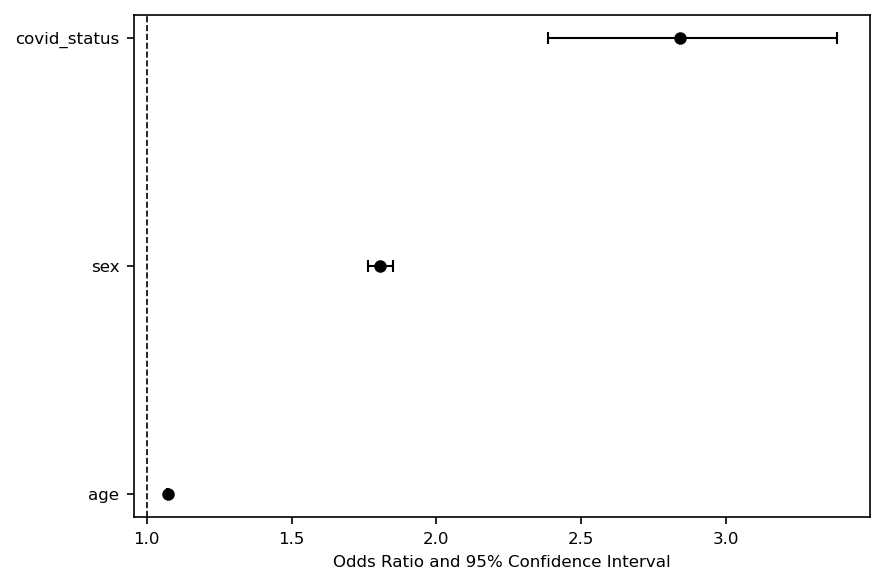

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), dpi=150)
ci = [odds.iloc[::-1]['Odds Ratio'] - odds.iloc[::-1]['5%'].values, odds.iloc[::-1]['95%'].values - odds.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=odds.iloc[::-1]['Odds Ratio'], y=odds.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

# Matching Preparation

In [64]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [65]:
covid_sample = covid.head(30000)
noncovid_sample = noncovid.head(200)

In [66]:
covid_sample

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
30123,0d9b71,0,69,0,1,1,1
30124,0032c6,0,33,0,1,1,1
30125,0cb27f,0,21,0,1,1,1
30126,15200b,0,52,1,1,1,1


In [67]:
full_sample_cohort = [covid_sample, noncovid_sample]

result = pd.concat(full_sample_cohort, ignore_index=True)

In [68]:
result

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
30195,169909,0,58,1,0,0,0
30196,159724,1,89,0,1,0,0
30197,133975,0,71,0,1,0,0
30198,114524,0,63,1,0,0,0


In [69]:
result = result[["age", "sex", "hypertension", "diabetes", "covid_status", "outcome"]]

In [70]:
X=result.drop(['covid_status', 'outcome'],axis='columns')
lr = LogisticRegression()
lr.fit(X,result['covid_status'])

LogisticRegression()

In [73]:
covid

,id,outcome,age,sex,hypertension,diabetes,covid_status
0,16169f,0,27,1,1,1,1
1,1009bf,0,24,1,1,1,1
2,167386,0,54,0,1,1,1
3,0b5948,0,30,1,1,1,1
4,0d01b5,1,60,0,0,0,1
...,...,...,...,...,...,...,...
566597,01ff60,0,58,1,1,0,1
566598,047cd1,0,48,0,1,1,1
566599,1beb81,0,49,0,1,1,1
566600,16fb02,0,43,0,1,1,1


In [74]:
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
pred_prob = lr.predict_proba(X)
result['ps'] = pred_prob[:, 1]

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

result['ps_logit'] = result['ps'].apply(lambda x: logit(x))

# Before Matching

In [75]:
result1 = result[result['covid_status'] == 0]
result2 = result[result['covid_status'] == 1]

[Text(0.5, 1.0, 'COVID Negative Probability Distribution')]

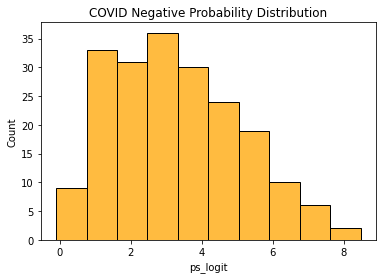

In [76]:
sns.histplot(data=result1, x='ps_logit', color = 'orange').set(title = "COVID Negative Probability Distribution")

[Text(0.5, 1.0, 'COVID Positive Probability Distribution')]

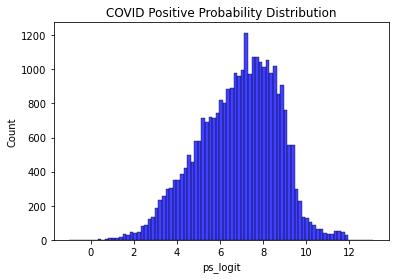

In [77]:
sns.histplot(data=result2, x='ps_logit', color="blue").set(title = "COVID Positive Probability Distribution")

# Matching

In [78]:
exclude=[]
def perfom_matching(row, indexes, df_data):
    current_index = row.name
    prop_score_logit = row['ps_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row['covid_status'] == 0) and (df_data.loc[idx]['covid_status'] == 1) and (idx not in exclude):
            exclude.append(idx)
            return int(idx)

def obtain_match_details(row, all_data, attribute, key):
    return all_data.loc[row[key]][attribute]

In [79]:
caliper=np.std(result['ps'])*.25
print(f'caliper (radius) is: {caliper:.4f}')

knn = NearestNeighbors(n_neighbors=200,algorithm='ball_tree',radius=caliper)
knn.fit(result[['ps_logit']])
distances, indexes = knn.kneighbors(result[['ps_logit']])

caliper (radius) is: 0.0056


In [80]:
result = result.reset_index()
del result['index']

In [81]:
result['matched_1']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_1'].isna()][result.columns]
control_hosp_match_1=pd.DataFrame(data=covid_hosp_match['matched_1'])

for attr in result.drop('matched_1',axis='columns'):
    control_hosp_match_1[attr]=control_hosp_match_1.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_1')
    
control_hosp_match_1=control_hosp_match_1.set_index('matched_1')

In [82]:
result['matched_2']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_2'].isna()][result.columns]
control_hosp_match_2=pd.DataFrame(data=covid_hosp_match['matched_2'])

for attr in result.drop(['matched_1','matched_2'],axis='columns'):
    control_hosp_match_2[attr]=control_hosp_match_2.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_2')
    
control_hosp_match_2=control_hosp_match_2.set_index('matched_2')

In [83]:
result['matched_3']=result.reset_index().apply(perfom_matching,axis='columns',args=(indexes, result))

covid_hosp_match=result[~result['matched_3'].isna()][result.columns]
control_hosp_match_3=pd.DataFrame(data=covid_hosp_match['matched_3'])

for attr in result.drop(['matched_1','matched_2','matched_3'],axis='columns'):
    control_hosp_match_3[attr]=control_hosp_match_3.apply(obtain_match_details,axis='columns',all_data=result,attribute=attr,key='matched_3')
    
control_hosp_match_3=control_hosp_match_3.set_index('matched_3')

In [84]:
all_matched_result=pd.concat([result[result['covid_status']==0],control_hosp_match_1,control_hosp_match_2,control_hosp_match_3],ignore_index=True)

# After Matching

In [85]:
matchedresult1 = all_matched_result[all_matched_result['covid_status'] == 0]
matchedresult2 = all_matched_result[all_matched_result['covid_status'] == 1]

[Text(0.5, 1.0, 'Matched COVID Negative Probability Distribution')]

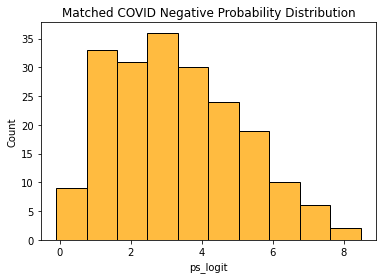

In [86]:
sns.histplot(data=matchedresult1, x='ps_logit', color = 'orange').set(title = "Matched COVID Negative Probability Distribution")

[Text(0.5, 1.0, 'Matched COVID Positive Probability Distribution')]

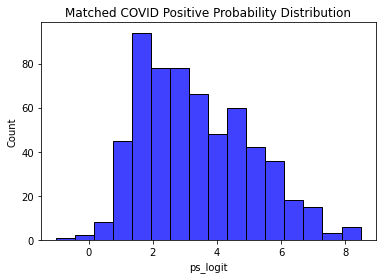

In [87]:
sns.histplot(data=matchedresult2, x='ps_logit', color="blue").set(title = "Matched COVID Positive Probability Distribution")

In [88]:
matched_covid_result = all_matched_result[all_matched_result['covid_status']==True]

In [89]:
noncovid_result = result[result['covid_status']==False]

In [90]:
result

,age,sex,hypertension,diabetes,covid_status,outcome,ps,ps_logit,matched_1,matched_2,matched_3
0,27,1,1,1,1,0,0.999865,8.911864,NaN,NaN,NaN
1,24,1,1,1,1,0,0.999902,9.235452,NaN,NaN,NaN
2,54,0,1,1,1,0,0.997101,5.840659,NaN,NaN,NaN
3,30,1,1,1,1,0,0.999814,8.588276,NaN,NaN,NaN
4,60,0,0,0,1,1,0.993422,5.017437,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
30195,58,1,0,0,0,0,0.995468,5.392075,21293.0,18519.0,113.0
30196,89,0,1,0,0,1,0.645987,0.601445,9873.0,21384.0,17148.0
30197,71,0,1,0,0,0,0.927100,2.542974,7816.0,22438.0,28397.0
30198,63,1,0,0,0,0,0.992254,4.852762,14401.0,7654.0,2325.0


# Basic Characteristics of Data Sets

In [91]:
def data_characteristics(data1, data2, data3):
    datasets = [data1, data2, data3]
    df = pd.DataFrame(index=['Age - Mean', 'Age - Standard Deviation', 'Male', 'Diabetes', 'Hypertension', 'Mortality'])
    a = 0
    for data in datasets:
        mean_age = data['age'].mean()
        std_age = data['age'].std()
        male_count = data['sex'].sum()
        diabetes_count = data['diabetes'].sum()
        hypertension_count = data['hypertension'].sum()
        mortality_count = data['outcome'].sum()
        total_count = len(data.index)
        male_percentage = '(' + str(round(male_count/total_count*100,2)) + "%" + ')'
        diabetes_percentage = '(' + str(round(diabetes_count/total_count*100,2)) + "%" + ')'
        hypertension_percentage = '(' + str(round(hypertension_count/total_count*100,2)) + "%" + ')'
        mortality_percentage = '(' + str(round(mortality_count/total_count*100,2)) + "%" + ')'
        df[a] = [mean_age, std_age, str(male_count) + ' ' + male_percentage, str(diabetes_count) + ' ' + diabetes_percentage, str(hypertension_count) + ' ' + hypertension_percentage, str(mortality_count) + ' ' + mortality_percentage]
        a += 1
    df.rename(columns = {0:'covid', 1:'noncovid', 2:'matched_covid'}, inplace = True)
    #df = df.astype({'covid':'int', 'noncovid':'int', 'matched_covid':'int'})
    return df

In [92]:
data_characteristics(covid, noncovid, matched_covid_result)

,covid,noncovid,matched_covid
Age - Mean,42.601102,74.047619,73.348333
Age - Standard Deviation,16.651157,13.437241,13.39176
Male,285830 (50.64%),618 (52.55%),291.0 (48.5%)
Diabetes,493638 (87.46%),495 (42.09%),268.0 (44.67%)
Hypertension,472008 (83.63%),844 (71.77%),443.0 (73.83%)
Mortality,35888 (6.36%),159 (13.52%),206.0 (34.33%)


# Basic Comparisons of COVID Negative Cohort vs Unmatched COVID Positive Cohort and COVID Negative Cohort vs Matched COVID Positive Cohort

## Age Comparison - (Independent Sample T-test)

In [93]:
from scipy.stats import chi2_contingency 
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [94]:
#m1 = mean age of cohort 1
#s1 = standard deviation of age of cohort 1
#c1 = total of cohort 1
#m2 = mean age of cohort 2
#s2 = standard deviation of age of cohort 2
#c2 = total of cohort 2

In [95]:
def ttest(m1, s1, c1, m2, s2, c2):
    mean1 = m1
    std1 =  s1
    count1 = c1
    mean2 = m2
    std2 = s2
    count2 = c2
    t2, p2 = ttest_ind_from_stats(mean1, std1, count1,
                                  mean2, std2, count2,
                                  equal_var=False)
    print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))
    print(p2)
    alpha = 0.05
    print("p value is " + str(p2)) 
    if (p2) <= alpha: 
        print('Dependent (reject H0)') 
    else: 
        print('Independent (H0 holds true)') 

In [96]:
ttest(42.6, 16.7, 564410, 74.0, 13.4, 1176)
## Non-COVID Age vs Unmatched COVID Age

ttest_ind_from_stats: t = -80.2282  p = 0
0.0
p value is 0.0
Dependent (reject H0)


In [97]:
ttest(73.3, 13.4, 600, 74.0, 13.4, 1176)
## Non-COVID Age vs Matched COVID Age

ttest_ind_from_stats: t = -1.04124  p = 0.297973
0.29797262145605863
p value is 0.29797262145605863
Independent (H0 holds true)


## Sex, Diabetes, Hypertension, Mortality Comparison - (Chi-Squared Test)

## Sex

In [98]:
#t1 = total of cohort 1
#c1 = count of individuals of a given category of cohort 1 (ex: number of diabetics)
#t1 = total of cohort 2
#c2 = count of individuals of a given category of cohort 2 (ex: number of diabetics)

In [99]:
#Chi-square analysis
def chisquared(t1, t2, c1, c2):
    total1 = t1
    total2 = t2
    cohort1 = c1
    cohort2 = c2
    data = [[total1 - cohort1, total2-cohort2], [cohort1, cohort2]]
    stat, p, dof, expected = chi2_contingency(data) 

    #if p value is >0.05, then it is significantly different
    alpha = 0.05
    print("p value is " + str(p)) 
    if (p) <= alpha: 
        print('Dependent (reject H0)') 
    else: 
        print('Independent (H0 holds true)') 

In [100]:
chisquared(564410, 1176, 285830, 618)
## Non-COVID Sex vs Unmatched COVID Sex

p value is 0.2010067405579496
Independent (H0 holds true)


In [101]:
chisquared(600, 1176, 291, 618)
## Non-COVID Sex vs Matched COVID Sex

p value is 0.11753778240278052
Independent (H0 holds true)


## Diabetes

In [102]:
chisquared(564410, 1176, 493638, 495)
## Non-COVID Diabetes vs Unmatched COVID Diabetes

p value is 0.0
Dependent (reject H0)


In [103]:
chisquared(600, 1176, 268, 495)
## Non-COVID Diabetes vs Matched COVID Diabetes

p value is 0.3240862915298277
Independent (H0 holds true)


## Hypertension

In [104]:
chisquared(564410, 1176, 472008, 844)
## Non-COVID Hypertension vs Unmatched COVID Hypertension

p value is 7.914862618240452e-28
Dependent (reject H0)


In [105]:
chisquared(600, 1176, 443, 844)
## Non-COVID Hypertension vs Matched COVID Hypertension

p value is 0.3869639237305297
Independent (H0 holds true)


## Mortality

In [106]:
chisquared(564410, 1176, 35888, 159)
## Non-COVID Mortality vs Unmatched COVID Mortality

p value is 1.7910684422580492e-23
Dependent (reject H0)


In [107]:
chisquared(600, 1176, 206, 159)
## Non-COVID Mortality vs Matched COVID Mortality

p value is 1.8937686184907647e-24
Dependent (reject H0)


## Statistics Tables

In [108]:
table = data_characteristics(covid, noncovid, matched_covid_result)
covid_noncovid_table = table[['noncovid', 'covid']]
covid_noncovid_table['significant'] = ["True", "-", "False", "True", "True", "True"]

In [109]:
covid_noncovid_table

,noncovid,covid,significant
Age - Mean,74.047619,42.601102,True
Age - Standard Deviation,13.437241,16.651157,-
Male,618 (52.55%),285830 (50.64%),False
Diabetes,495 (42.09%),493638 (87.46%),True
Hypertension,844 (71.77%),472008 (83.63%),True
Mortality,159 (13.52%),35888 (6.36%),True


In [110]:
table = data_characteristics(covid, noncovid, matched_covid_result)
matchedcovid_noncovid_table = table[['noncovid', 'matched_covid']]
matchedcovid_noncovid_table['significant'] = ["False", "-", "False", "False", "False", "True"]

In [111]:
matchedcovid_noncovid_table 

,noncovid,matched_covid,significant
Age - Mean,74.047619,73.348333,False
Age - Standard Deviation,13.437241,13.39176,-
Male,618 (52.55%),291.0 (48.5%),False
Diabetes,495 (42.09%),268.0 (44.67%),False
Hypertension,844 (71.77%),443.0 (73.83%),False
Mortality,159 (13.52%),206.0 (34.33%),True


# Extra Credit Visualization

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

In [113]:
covid = pd.read_csv(r'C:\Users\jaimv\Downloads\covid.csv')
noncovid = pd.read_csv(r'C:\Users\jaimv\Downloads\noncovid.csv')

In [114]:
noncovid.rename({'ID': 'id', 'gendera': 'sex', 'hypertensive': 'hypertension'}, axis=1, inplace=True)
noncovid = noncovid.dropna()

In [115]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsRegressor

df = noncovid
X = df.age.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100)

# Model #1
knn_dist = KNeighborsRegressor(10, weights='distance')
knn_dist.fit(X, df.heart_rate)
y_dist = knn_dist.predict(x_range.reshape(-1, 1))

# Model #2
knn_uni = KNeighborsRegressor(10, weights='uniform')
knn_uni.fit(X, df.heart_rate)
y_uni = knn_uni.predict(x_range.reshape(-1, 1))

fig = px.scatter(df, x='age', y='heart_rate', color='sex', opacity=0.65)
fig.add_traces(go.Scatter(x=x_range, y=y_uni, name='Weights: Uniform'))
fig.add_traces(go.Scatter(x=x_range, y=y_dist, name='Weights: Distance'))
fig.show()


In [116]:
X = df.age.values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100)

# Model #1
knn_dist = KNeighborsRegressor(10, weights='distance')
knn_dist.fit(X, df.glucose)
y_dist = knn_dist.predict(x_range.reshape(-1, 1))

# Model #2
knn_uni = KNeighborsRegressor(10, weights='uniform')
knn_uni.fit(X, df.glucose)
y_uni = knn_uni.predict(x_range.reshape(-1, 1))

fig = px.scatter(df, x='age', y='glucose', color='sex', opacity=0.65)
fig.add_traces(go.Scatter(x=x_range, y=y_uni, name='Weights: Uniform'))
fig.add_traces(go.Scatter(x=x_range, y=y_dist, name='Weights: Distance'))
fig.show()



In [117]:
#pip freeze > requirements. txt